In [7]:
!nvidia-smi


Sun Dec 12 11:25:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 48.1MB/s]


In [9]:
!unzip -qq ECG5000.zip

In [10]:
!pip install  -qq arff2pandas

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil

import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid",palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE=["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=12,8

RANDOM_SEED =42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)








In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)
  

In [14]:
train.head(3)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1


In [15]:
with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [16]:
train.head(3)


,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1


In [17]:
df = train.append(test)
df.shape

(5000, 141)

In [18]:
df.head(2)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1


In [19]:
df = df.sample(frac=1.0)


*Normal (N)
R-on-T Premature Ventricular Contraction (R-on-T PVC)
Premature Ventricular Contraction (PVC)
Supra-ventricular Premature or Ectopic Beat (SP or EB)
Unclassified Beat (UB).



In [20]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [21]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.head(2)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.82257,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.59191,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.55454,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.76908,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1


LOG


In [22]:
df.dtypes

att1@NUMERIC      float64
att2@NUMERIC      float64
att3@NUMERIC      float64
att4@NUMERIC      float64
att5@NUMERIC      float64
                   ...   
att137@NUMERIC    float64
att138@NUMERIC    float64
att139@NUMERIC    float64
att140@NUMERIC    float64
target             object
Length: 141, dtype: object

In [23]:
new = df
new.head(2)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.82257,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.59191,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.55454,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.76908,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1


In [24]:
training = new.iloc[0:4500]
validation = new.iloc[4500:5000]
trainplusvalidation = new.iloc[0:5000]
forecast = new.iloc[4900:5000]

In [25]:
training

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.116396,-0.2304

In [26]:
y_train = training['target']
x_train = training.drop(columns=['target'])

In [27]:
y_valid = validation['target']
x_valid = validation.drop(columns=['target'])

In [28]:
y_trainplusvalid = trainplusvalidation['target']
x_trainplusvalid = trainplusvalidation.drop(columns=['target'])
x_forecast = forecast.drop(columns=['target'])


In [29]:
x_train

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.573868,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.444721,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.340341,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.9591

In [30]:
y_train

1001    1
2086    1
2153    1
555     1
205     1
       ..
4036    2
1356    1
888     1
3219    2
1886    1
Name: target, Length: 4500, dtype: object

In [31]:
x_forecast

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
3145,-0.279995,-0.887037,-1.203541,-1.707776,-1.825967,-1.933866,-1.962609,-1.776699,-1.630844,-1.417339,-1.144581,-0.766859,-0.370051,-0.277068,-0.297831,-0.124365,0.125260,0.279513,0.343198,0.377832,0.395430,0.407945,0.414121,0.384216,0.365411,0.410497,0.441340,0.410302,0.335392,0.285817,0.334161,0.394423,0.395430,0.405912,0.412005,0.385595,0.350402,0.331791,0.363421,0.408591,...,0.455468,0.479811,0.493070,0.476404,0.425449,0.412343,0.459713,0.437229,0.380421,0.413367,0.428750,0.407072,0.410439,0.372685,0.329236,0.378620,0.470477,0.503931,0.409483,0.203323,0.005185,-0.130947,-0.230257,-0.179262,-0.024834,-0.028715,-0.252923,-0.629824,-1.090504,-1.578951,-2.174046,-2.800794,-3.507024,-4.073475,-4.022491,-3.656692,-2.771562,-1.776220,-1.635745,-0.456314
1954,-1.297291,-2.730990,-3.655680,-4.528419,-4.339705,-3.444625,-2.092615,-1.659386,-1.235329,-0.450333,-0.288641,-0.299700,-0.309953,-0.307810,-0.326204,-0.205862,-0.290340,-0.363358,-0.315669,-0.329902,-0.382720,-0.394296,-0.368110,-0.424076,-0.473785,-0.553449,-0.532110,-0.458601,-0.545712,-0.651486,-0.683767,-0.715299,-0.777298,-0.781838,-0.745594,-0.734598,-0.740644,-0.730359,-0.670718,-0.528427,...,1.075918,1.166346,1.357454,1.603589,1.748101,1.722138,1.671547,1.482604,1.298810,1.078834,0.806926,0.632717,0.309509,-0.081098,-0.191107,-0.201853,-0.256078,-0.255774,-0.305749,-0.307473,-0.249045,-0.286772,-0.255846,-0.212832,-0.281520,-0.259240,-0.252618,-0.195770,-0.105829,0.415190,1.030636,1.232137,1.309036,1.689524,1.757270,1.353580,0.702903,0.266076,0.304472,-0.853037
4098,0.901569,0.810158,0.217655,-0.389432,-0.750673,-1.049979,-1.239300,-1.130137,-0.756450,-0.456048,-0.455100,-0.377911,0.016091,0.129736,0.090804,0.100229,0.090937,0.053439,0.105492,0.134296,0.142850,0.125170,0.101416,0.074923,0.058286,0.062245,0.056029,0.058130,0.039939,0.038334,0.038140,0.039886,0.003754,-0.021397,0.003176,-0.071708,-0.091524,-0.080826,-0.105096,-0.119589,...,0.415354,0.417766,0.388622,0.362126,0.378904,0.380336,0.387223,0.382797,0.344575,0.373348,0.381952,0.334976,0.346924,0.323907,0.345000,0.320697,0.339996,0.379355,0.411057,0.479862,0.597588,0.646845,0.735699,0.816916,0.920844,1.184590,1.462416,1.494234,1.288855,1.031591,0.708842,0.471887,-0.007607,-0.693430,-1.512484,-2.690625,-3.616223,-4.799445,-5.484735,-6.038676
2604,-0.279996,-2.627527,-3.818375,-4.090528,-3.762565,-3.090997,-2.034890,-1.660274,-1.320603,-0.661428,-0.443695,-0.477103,-0.504807,-0.445799,-0.484244,-0.479195,-0.419861,-0.480057,-0.416451,-0.523153,-0.504417,-0.536943,-0.621623,-0.571231,-0.662879,-0.636573,-0.619546,-0.707194,-0.697276,-0.749257,-0.807611,-0.861983,-0.927887,-0.901793,-0.877622,-0.857551,-0.797038,-0.831257,-0.825924,-0.760621,...,1.381090,1.586878,1.716366,1.706833,1.615809,1.536779,1.356956,1.162520,0.970911,0.767841,0.457710,0.147312,-0.055911,-0.181593,-0.23

In [32]:
import sklearn
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(x_train, y_train)
linReg.score(x_train, y_train)

0.6269894848550521

In [33]:
import statsmodels.api as sm
X2 = sm.add_constant(x_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [34]:
X2

,const,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1001,1.0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,...,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,1.0,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,...,1.573868,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,1.0,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,...,1.444721,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,1.0,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,...,1.340341,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.116396,-

In [35]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [36]:
est = sm.OLS(y_train.astype(float),X2.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     52.34
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:25:46   Log-Likelihood:                -2906.1
No. Observations:                4500   AIC:                             6094.
Df Residuals:                    4359   BIC:                             6998.
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2756      0.041     55.

In [37]:
y_pred = linReg.predict(x_valid)

In [38]:
y_pred

array([2.14405053e+00, 1.00515783e+00, 8.56653533e-01, 1.01948221e+00,
       8.66154310e-01, 1.44015090e+00, 7.99514462e-01, 2.07618654e+00,
       2.46205221e+00, 9.25918740e-01, 9.98213892e-01, 2.19077456e+00,
       1.00810741e+00, 1.02761053e+00, 1.90592745e+00, 1.02604326e+00,
       8.26436439e-01, 7.26175498e-01, 1.28513243e+00, 8.49753183e-01,
       2.62456179e+00, 2.14186579e+00, 1.29231859e+00, 2.09545018e+00,
       2.09523168e+00, 9.40425234e-01, 1.94720076e+00, 1.19754439e+00,
       9.69808319e-01, 9.54541520e-01, 9.33590613e-01, 2.16001529e+00,
       1.99268473e+00, 2.18358418e+00, 2.23100079e+00, 2.41196402e+00,
       9.67098750e-01, 2.63853888e+00, 8.93594159e-01, 2.54269601e+00,
       1.33006934e+00, 9.48436246e-01, 1.94738183e+00, 2.01457394e+00,
       1.64357310e+00, 2.09925090e+00, 2.58501799e+00, 9.35515364e-01,
       7.80233057e-01, 1.99461155e+00, 1.14215873e+00, 1.02856634e+00,
       4.85914339e-01, 1.19867463e+00, 2.15694406e+00, 1.42890133e+00,
      

In [39]:
new = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})
new.sort_index()

,Actual,Predicted
2,1,1.155674
4,1,1.095124
12,1,0.755377
16,1,0.908821
24,1,1.035711
...,...,...
4453,2,2.522166
4485,2,2.098250
4486,2,2.510418
4492,2,1.857889


In [40]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

clf.score(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9577777777777777

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


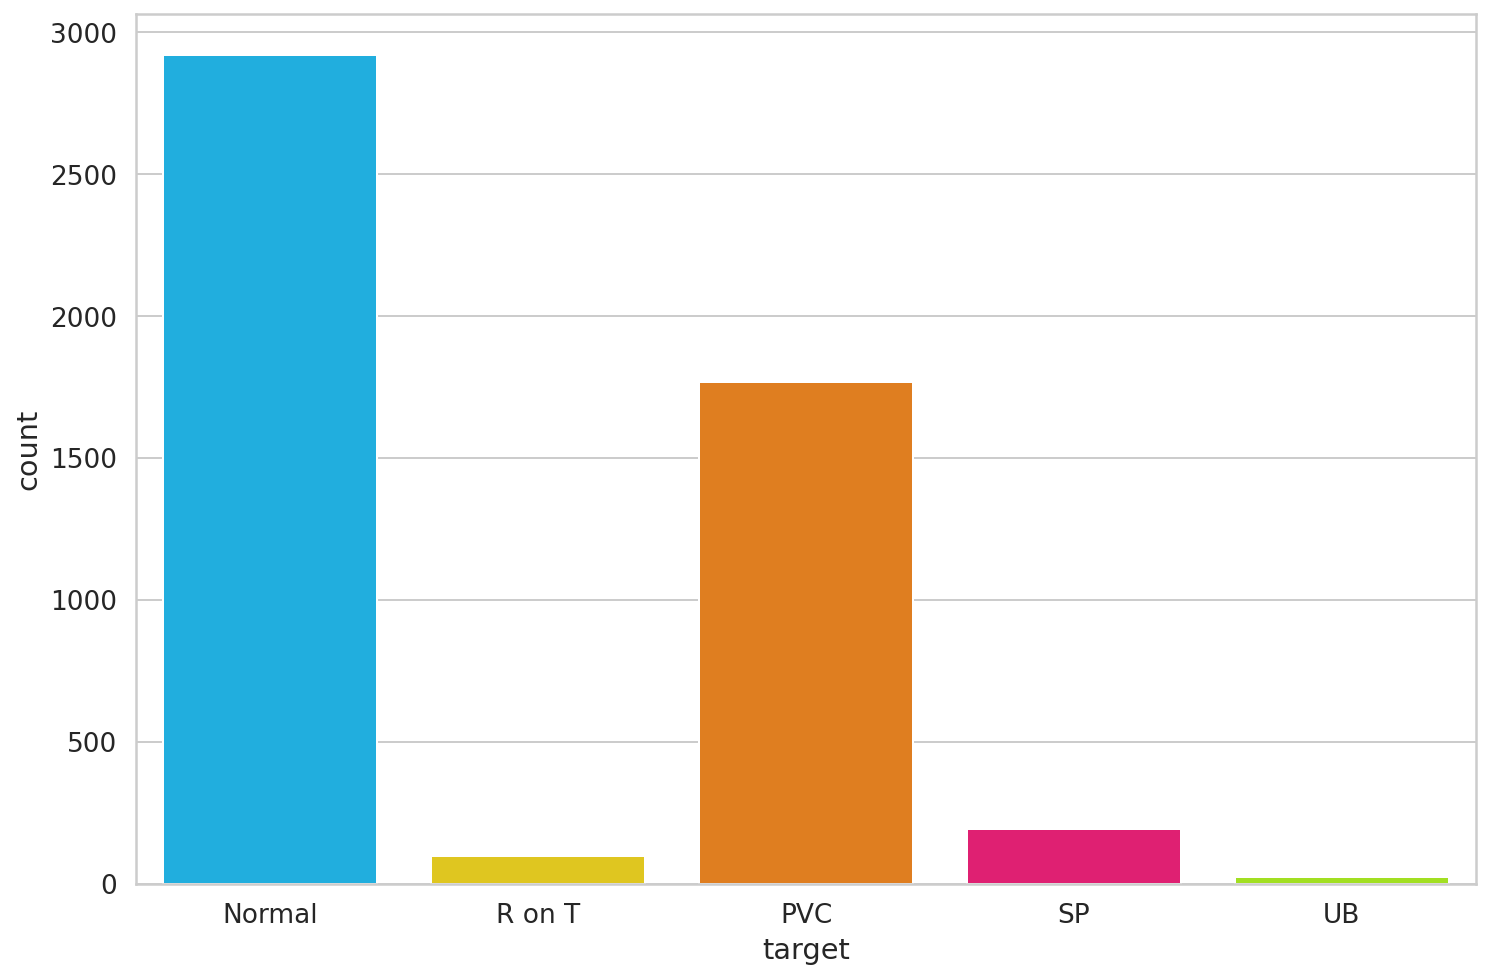

In [41]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [42]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

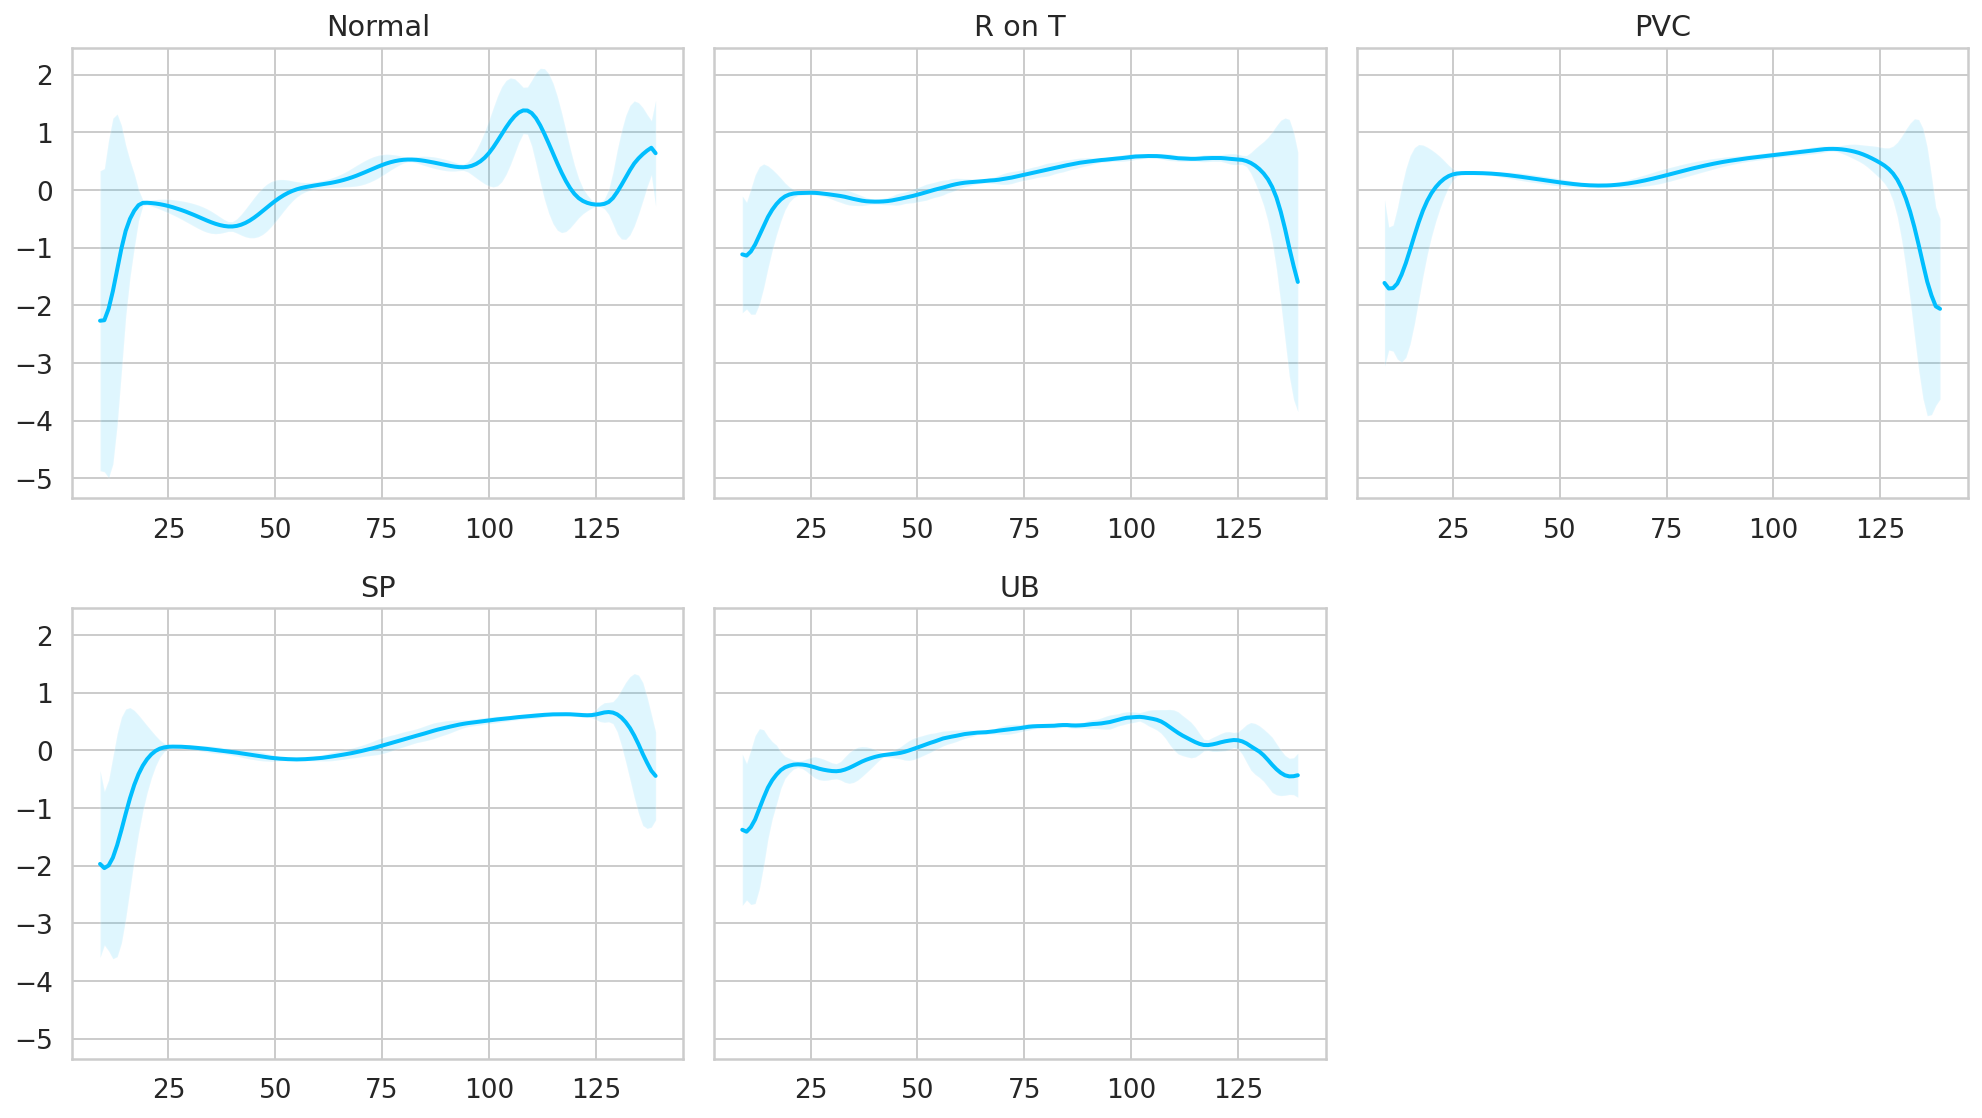

In [43]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [44]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [45]:
normal_df.head(2)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.82257,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.59191,...,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.55454,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.76908,...,1.573868,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517


In [46]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [47]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.5, 
  random_state=RANDOM_SEED
)

In [48]:
train_df.shape

(2481, 140)

In [49]:
test_df.shape

(219, 140)

In [50]:
test_df.head(2)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1098,-0.782978,-2.887577,-4.009258,-4.448407,-4.050075,-3.526736,-2.332674,-1.548725,-1.370806,-0.699660,-0.437804,-0.493976,-0.463848,-0.445093,-0.340682,-0.357893,-0.313054,-0.489623,-0.435521,-0.392165,-0.448641,-0.333000,-0.433982,-0.413450,-0.381617,-0.494598,-0.424333,-0.417755,-0.494145,-0.554220,-0.608741,-0.597094,-0.619051,-0.660503,-0.636751,-0.683238,-0.602431,-0.564904,-0.444475,-0.408666,...,1.321305,1.489269,1.697209,1.806850,1.702831,1.740809,1.531675,1.369316,1.275826,0.921989,0.678680,0.282524,0.073475,-0.066119,-0.098408,-0.045476,-0.104375,-0.130685,-0.125344,-0.182189,-0.154211,-0.120712,-0.128839,-0.087568,-0.129338,-0.166840,-0.086318,-0.034905,0.208591,0.782276,1.003402,1.089028,1.396124,1.378988,1.034615,0.621094,0.644381,0.857342,0.109038,-2.023731
245,-0.490446,-2.200742,-3.232344,-4.091743,-4.200020,-3.769176,-3.161289,-1.918228,-1.359980,-1.288644,-0.613338,-0.370112,-0.213220,-0.223961,-0.364263,-0.279189,-0.326240,-0.241584,-0.248874,-0.208296,-0.286450,-0.362745,-0.254670,-0.342831,-0.350467,-0.240857,-0.361892,-0.507227,-0.377788,-0.322056,-0.543917,-0.629927,-0.456313,-0.499804,-0.421947,-0.525227,-0.554531,-0.360021,-0.350779,-0.631597,...,1.881351,1.749691,1.650275,1.574041,1.269585,1.064036,1.024201,1.013957,0.511157,-0.022840,-0.049982,-0.220660,-0.303771,-0.206949,-0.327399,-0.215569,-0.237049,-0.234784,-0.222848,-0.076809,-0.363508,-0.489465,-0.173920,-0.227487,-0.268061,-0.087861,0.214961,0.569367,0.980160,1.240450,1.227328,1.441360,1.724556,1.479102,0.777006,0.031383,-0.112843,0.017645,-0.281541,-1.711292


LOGISTIC

In [51]:
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

In [52]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [53]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [54]:
train_dataset[0]

tensor([[ 2.4590e-01],
        [-2.3817e+00],
        [-3.3791e+00],
        [-4.1506e+00],
        [-4.3622e+00],
        [-3.6047e+00],
        [-2.2038e+00],
        [-1.6929e+00],
        [-1.4116e+00],
        [-4.5316e-01],
        [-2.4718e-01],
        [-3.0594e-01],
        [-3.0417e-01],
        [-2.8427e-01],
        [-3.1557e-01],
        [-3.4547e-01],
        [-2.9497e-01],
        [-2.6481e-01],
        [-2.9031e-01],
        [-3.4225e-01],
        [-2.9522e-01],
        [-2.9572e-01],
        [-3.0982e-01],
        [-3.0441e-01],
        [-2.9467e-01],
        [-2.8537e-01],
        [-5.3138e-01],
        [-4.3836e-01],
        [-4.7725e-01],
        [-5.1942e-01],
        [-6.5864e-01],
        [-6.1887e-01],
        [-6.9422e-01],
        [-7.1705e-01],
        [-7.0027e-01],
        [-7.2061e-01],
        [-8.0253e-01],
        [-6.7490e-01],
        [-6.7998e-01],
        [-6.5681e-01],
        [-5.8269e-01],
        [-5.0120e-01],
        [-4.1482e-01],
        [-4

In [55]:
from torch import nn, optim
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [56]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [57]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [58]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [59]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [60]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=15
)

Epoch 1: train loss 80.64377603680796 val loss 56.074494906212095
Epoch 2: train loss 53.596441862420754 val loss 50.97850634082812
Epoch 3: train loss 50.76555237237699 val loss 50.5932215512071
Epoch 4: train loss 47.18252140492597 val loss 38.55995715589828
Epoch 5: train loss 38.567540709600486 val loss 34.13807144339226
Epoch 6: train loss 31.485869994619016 val loss 34.21489381136959
Epoch 7: train loss 28.14217784009793 val loss 29.27274487552033
Epoch 8: train loss 27.039709269543994 val loss 28.54332350813635
Epoch 9: train loss 25.448532275546228 val loss 27.93911413950463
Epoch 10: train loss 24.544686475044198 val loss 25.09636888983043
Epoch 11: train loss 23.054692868406086 val loss 21.536165041466283
Epoch 12: train loss 22.752381355134965 val loss 25.156717113163918
Epoch 13: train loss 21.851855194217876 val loss 22.99528556545031
Epoch 14: train loss 20.882058835904093 val loss 19.947559648452827
Epoch 15: train loss 19.962386134169556 val loss 19.37531881463038


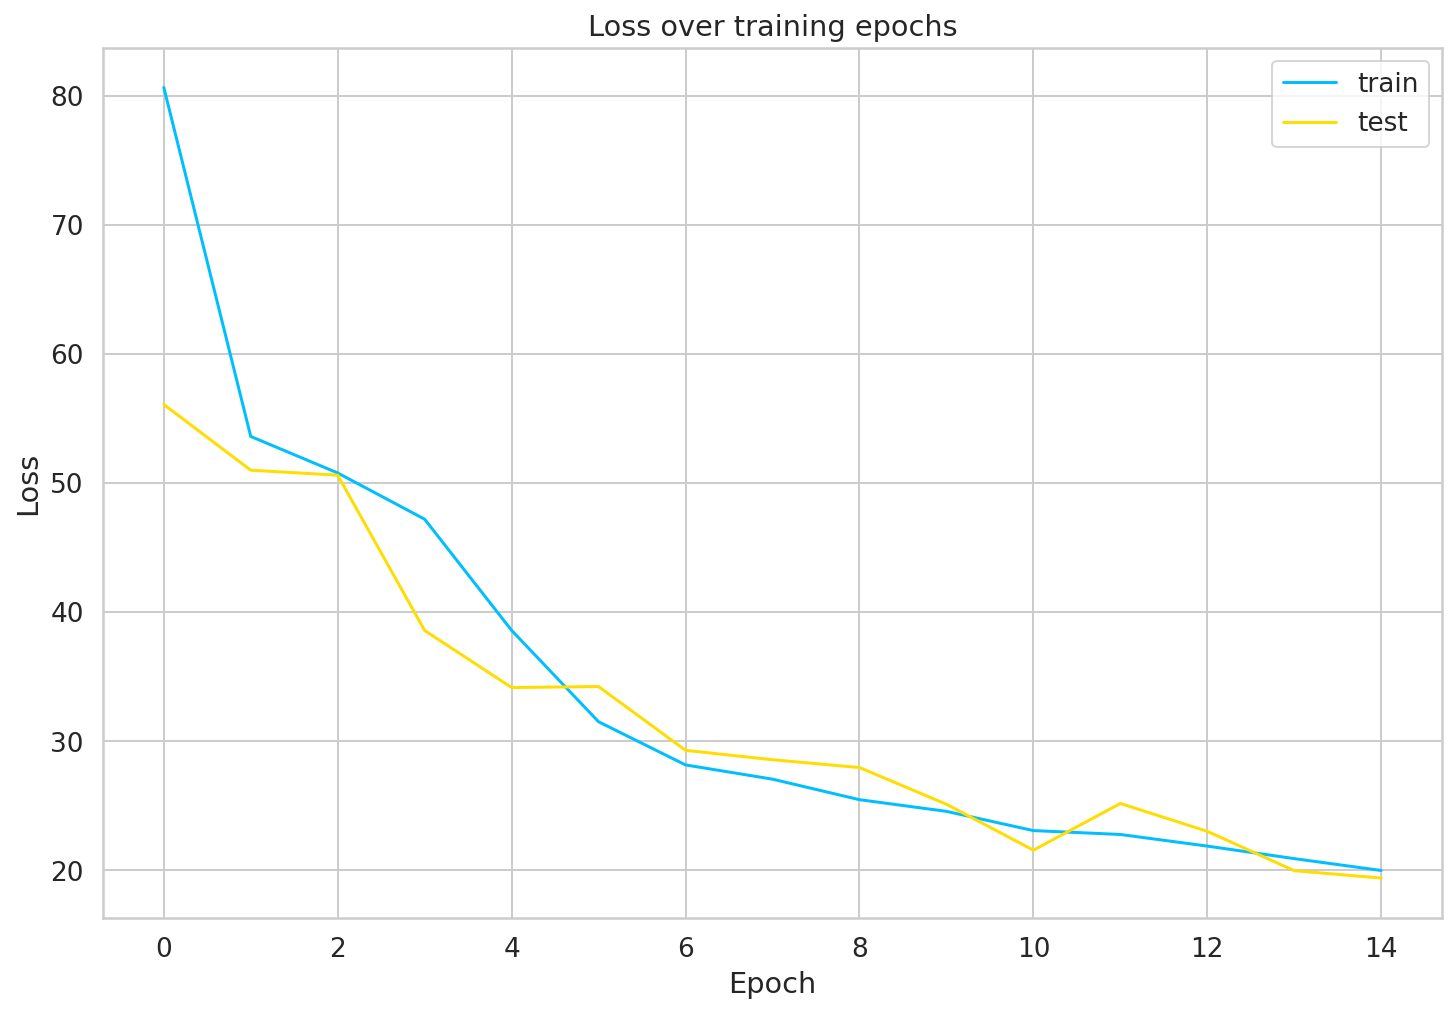

In [61]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [62]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [63]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


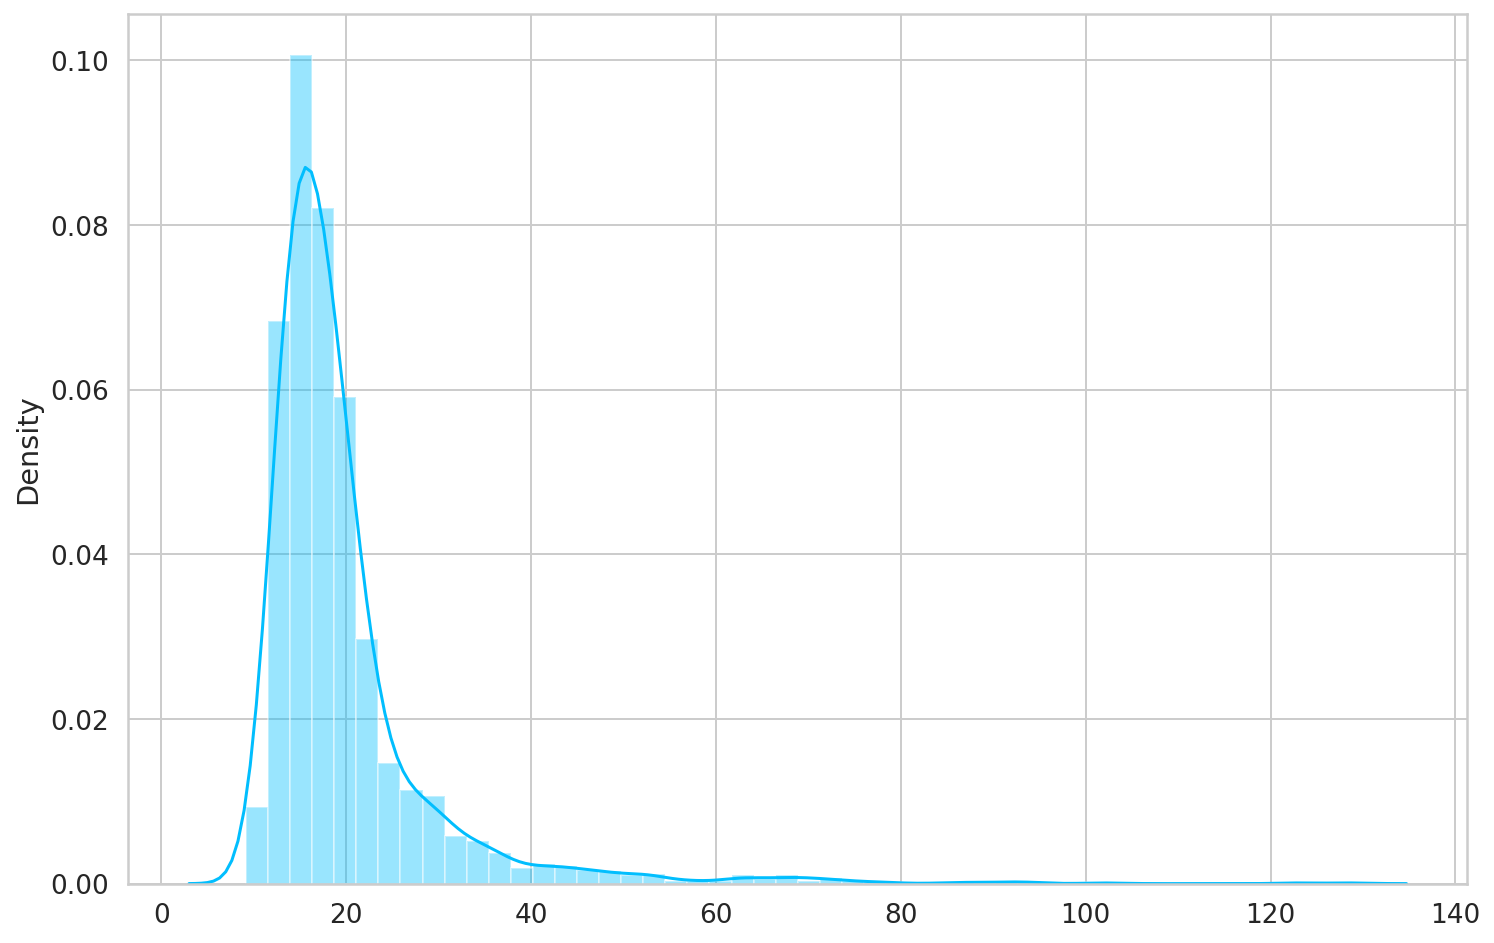

In [64]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [65]:
THRESHOLD = 26

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


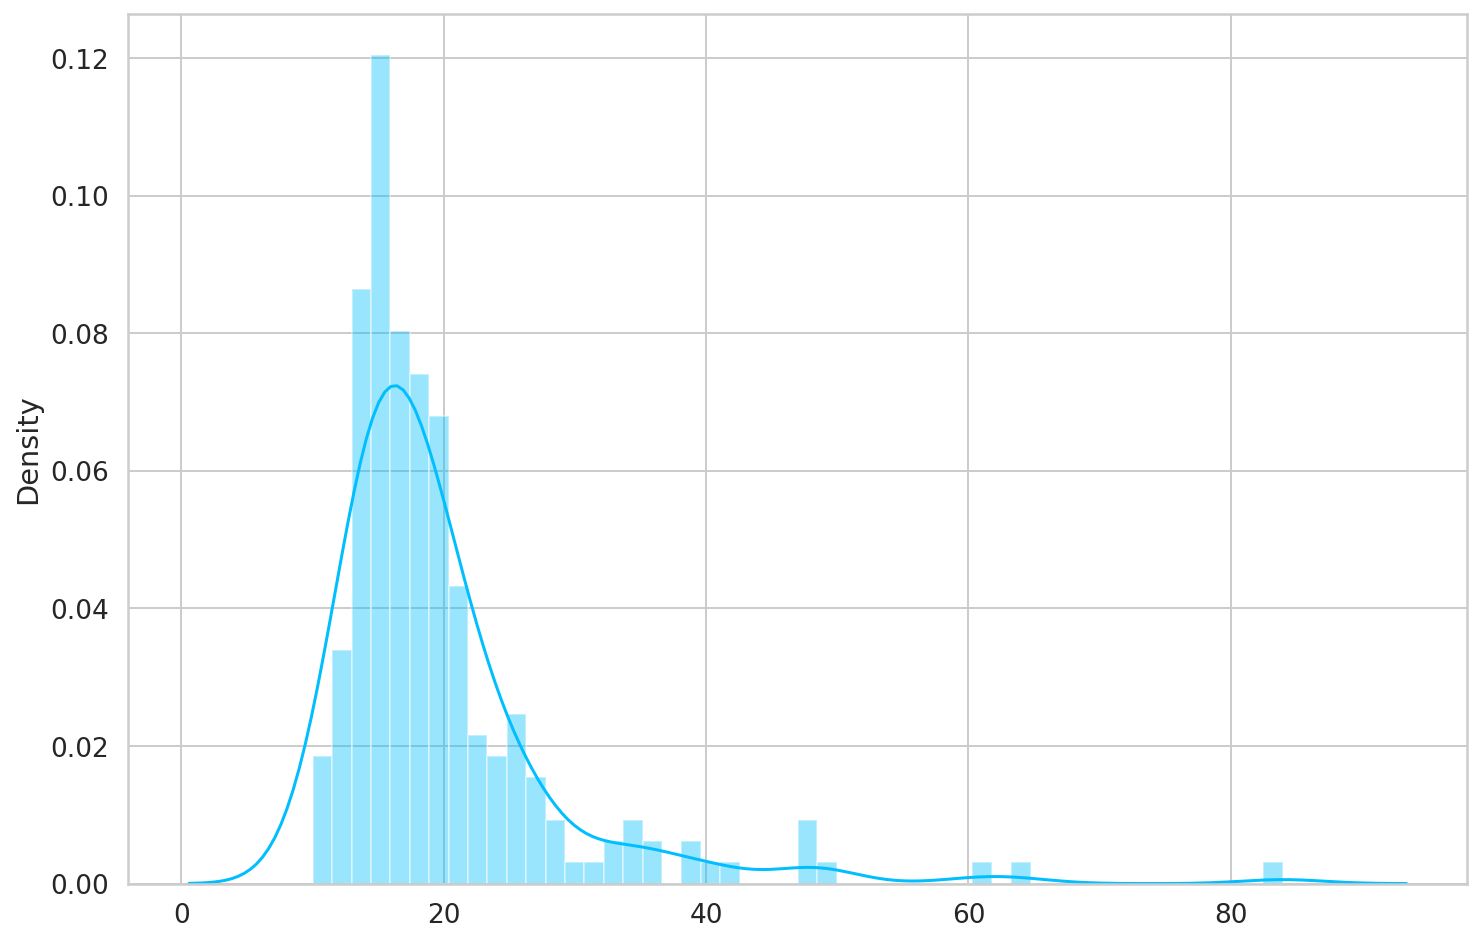

In [66]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [67]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 189/219


In [68]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


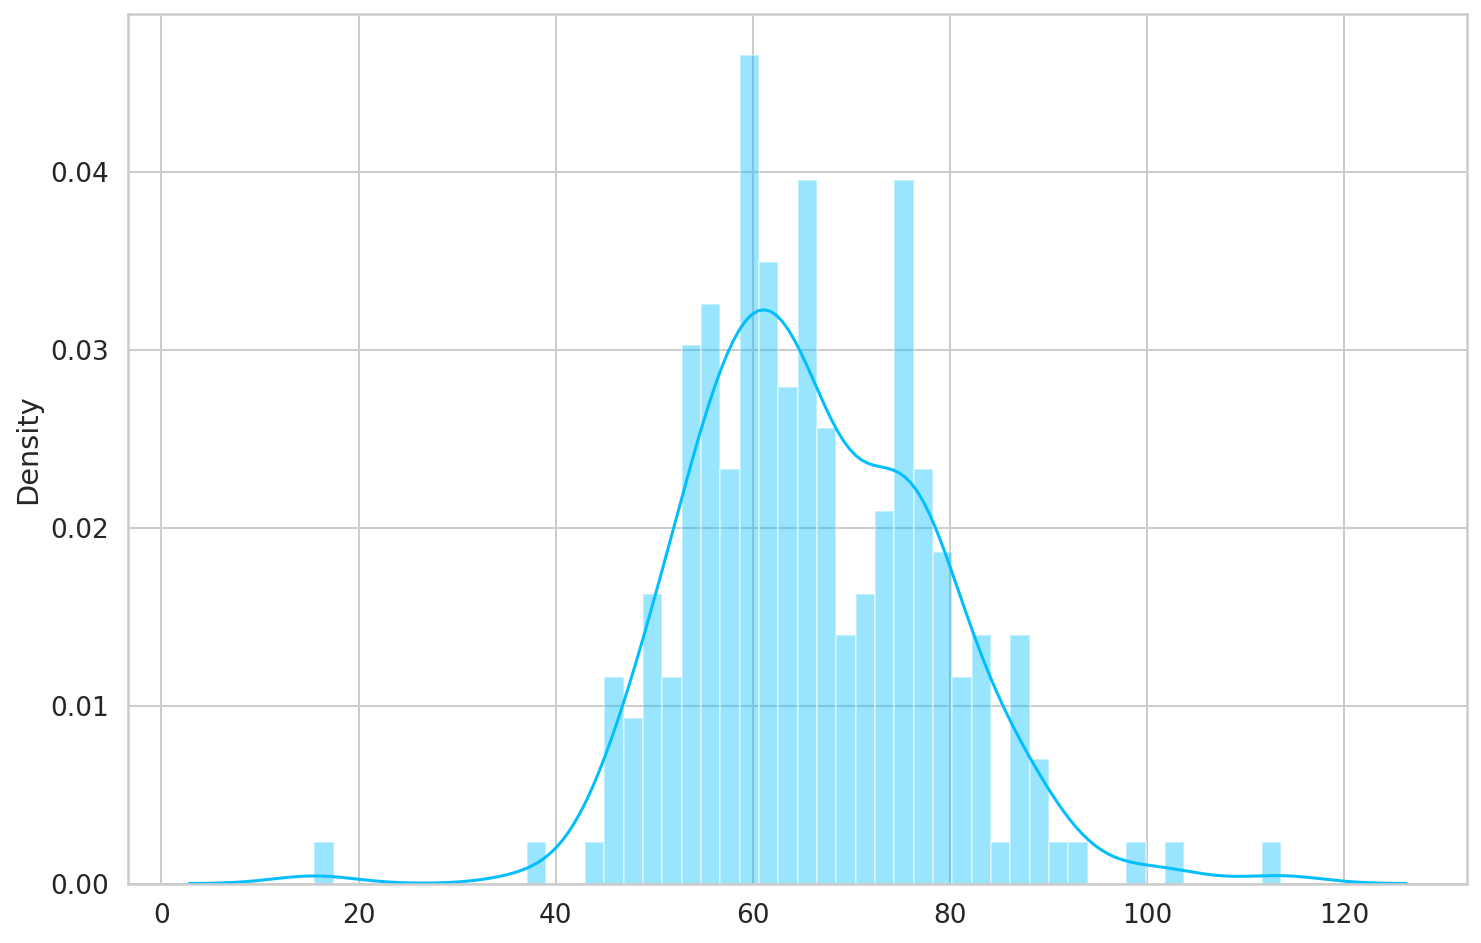

In [69]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [70]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 218/219


In [71]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

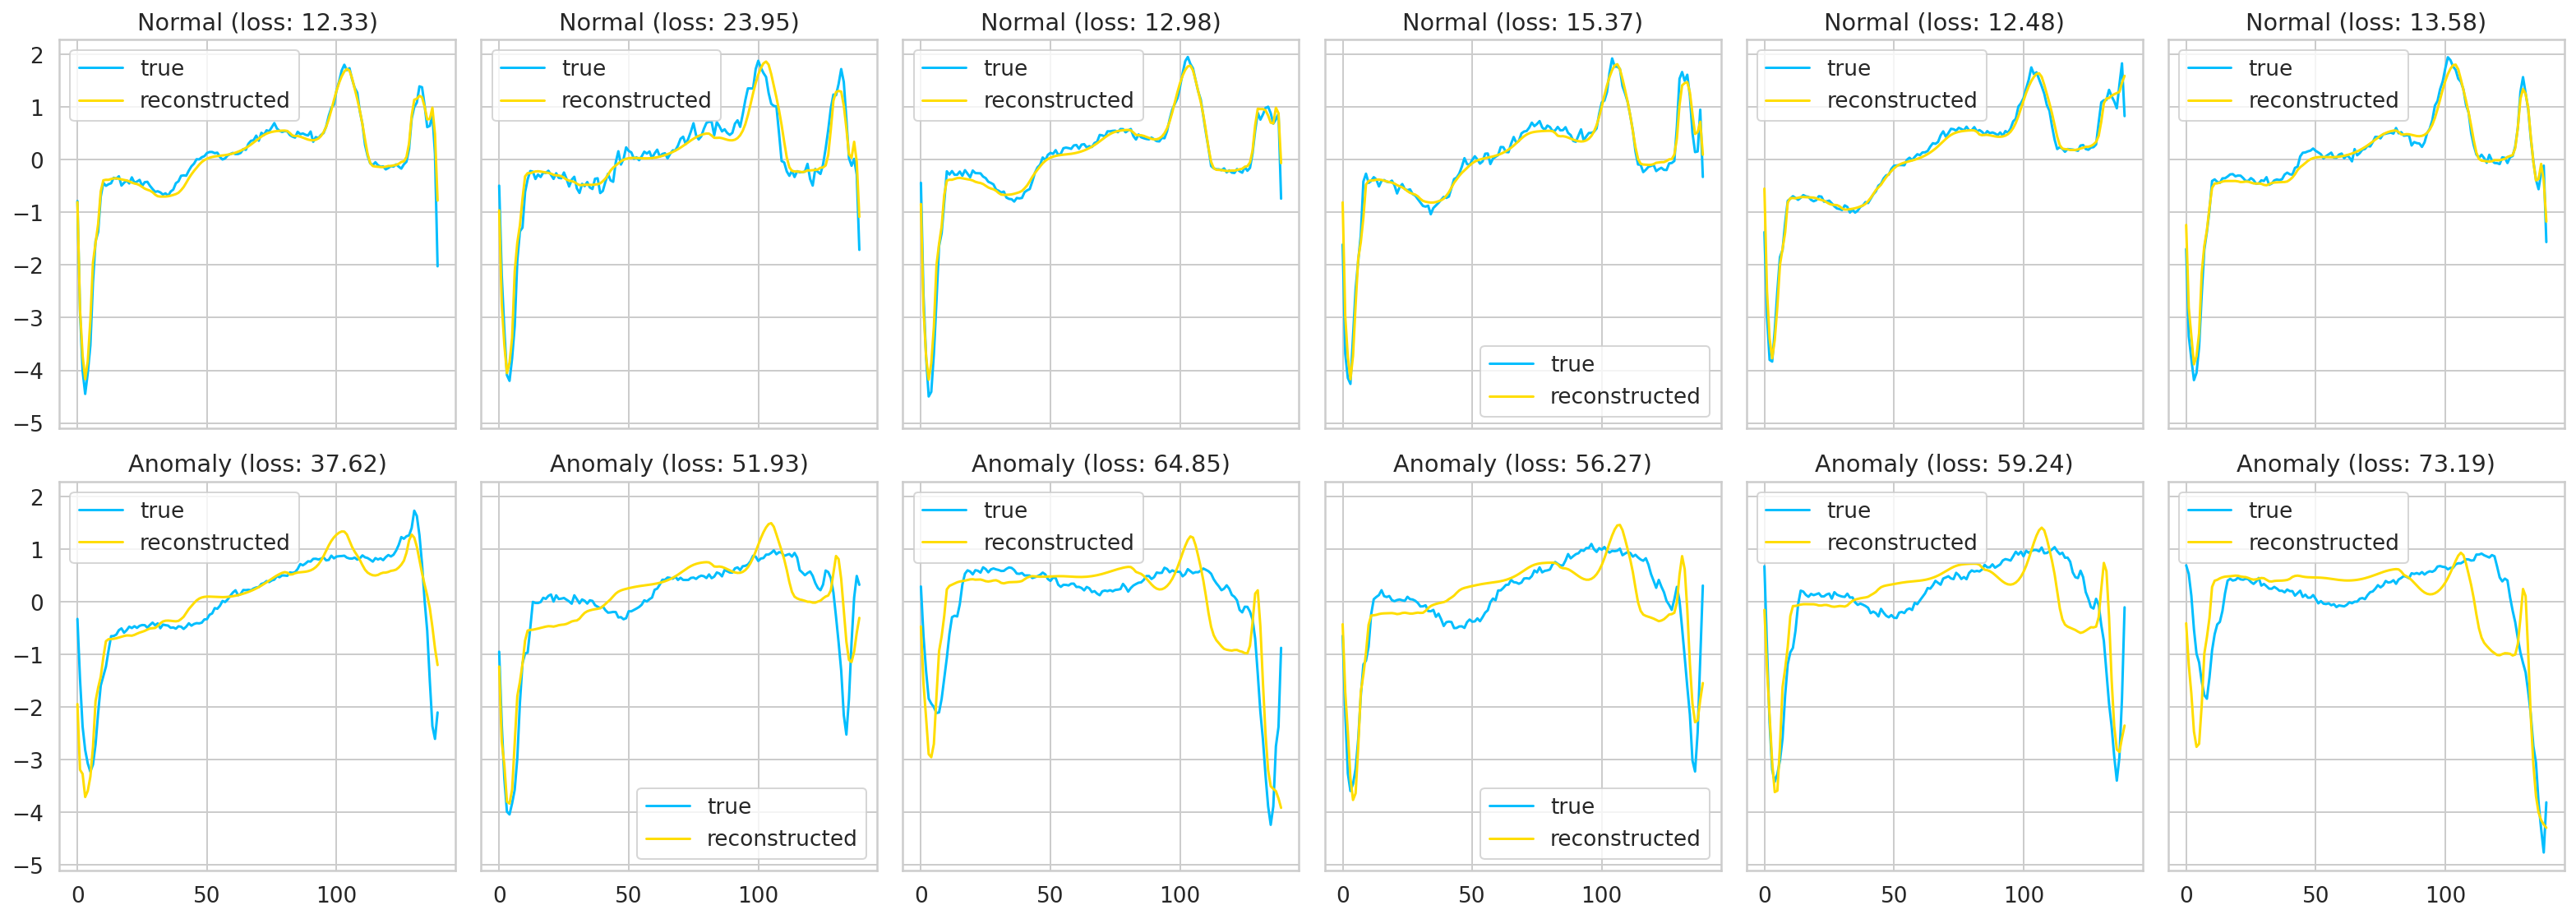

In [72]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();